# Diffusion Model for MNIST Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.distributions as D

import torchvision
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# let it use cuda if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
T = 200
learning_rate = 0.01
initial_rho_lr = 0.2
batch_size = 64
min_beta = 1e-4
max_beta = 1e-1

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:03<00:00, 3141023.24it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 489646.85it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 4428165.65it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 9302016.00it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class GaussianFourierProjection(nn.Module):
# Gaussian random features for encoding time steps.
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x * self.W * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
# A fully connected layer that reshapes outputs to feature maps.
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]

In [ ]:
class Diffusion(nn.Module):
    def __init__(self, model, n_steps, device, min_beta, max_beta):
        super().__init__()
        self.model = model
        self.n_steps = n_steps
        self.device = device
        self.min_beta = min_beta
        self.max_beta = max_beta

        # Initialize beta, alpha, and alpha bar
        self.beta = torch.linspace(min_beta, max_beta, n_steps, dtype=torch.float32).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, axis=0)

        self.sqrt_alpha_bar = self.alpha_bar ** 0.5
        self.sqrt_one_minus_alpha_bar = (1 - self.alpha_bar) ** 0.5


    def predict_next(self, xt, t):
        # Compute mu(xt, t)
        mu = self.model(xt, t)
        return mu

## Training

In [ ]:
#Example UNet
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class ScoreNet(nn.Module):
# A time-dependent score-based model with conditional mean computation."""

    def __init__(self, channels=[32, 64, 128, 256], embed_dim=256, group_num=4):

        super().__init__()

        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
             nn.Linear(embed_dim, embed_dim))

        # encoders
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(group_num, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(group_num, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(group_num, num_channels=channels[2])

        # decoders
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(group_num, num_channels=channels[3])
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(group_num, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(group_num, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(group_num, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)

    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))

        #--encoder
        h1 = self.conv1(x)
        h1 += self.dense1(embed)
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)


        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)


        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)


        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)


        #--decoder
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)

        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)

        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)

        h = self.tconv1(torch.cat([h, h1], dim=1))

        return h

In [ ]:
def loss_function_epsilon(diffusion, X_batch, device):
    batch_size = len(X_batch)
    n_steps = diffusion.n_steps

    # Draw random time steps for all examples in the batch using exponential distribution
    exponential_dist = D.Exponential(torch.tensor([0.03]))
    t_batch = exponential_dist.sample((batch_size, 1)).long().to(device).view(-1,1)
    t_batch = torch.clamp(t_batch, 0, n_steps-1)

    # Draw random vector j from N(0,I)
    noisej = torch.randn(X_batch.shape, device=device)

    # Produce Xtj
    xtj = diffusion.alpha_bar[t_batch].view(-1, 1, 1, 1) * X_batch + diffusion.sqrt_one_minus_alpha_bar[t_batch].view(-1, 1, 1, 1) * noisej


    # Run through the model
    e = diffusion.predict_next(xtj, t_batch)

    # Calculate loss
    loss = torch.sum((noisej - e) ** 2) / batch_size

    return loss

In [ ]:
score_net = ScoreNet().to(device)
diffusion = Diffusion(score_net, T, device, min_beta, max_beta).to(device)

In [ ]:
optimizer = optim.Adam([
    {'params': list(score_net.parameters()), 'lr': learning_rate},
])

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    score_net.train()

    train_loss = 0.0
    for batch_idx, (X_batch, target) in enumerate(train_loader):
        X_batch = X_batch.to(device)

        loss = loss_function_epsilon(diffusion, X_batch, device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)


    train_loss /= len(train_loader.dataset)

    # Validate the model
    score_net.eval()

    valid_loss = 0.0
    with torch.no_grad():
        for X_batch, _ in train_loader:
            X_batch = X_batch.to(device)

            loss = loss_function_epsilon(diffusion, X_batch, device)
            valid_loss += loss.item() * X_batch.size(0)

    valid_loss /= len(train_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.5f}, Valid Loss: {valid_loss:.5f}')

    scheduler.step()

Epoch 1/5, Train Loss: 381.79659, Valid Loss: 226.96795
Epoch 2/5, Train Loss: 167.94311, Valid Loss: 122.43967
Epoch 3/5, Train Loss: 190.99344, Valid Loss: 206.06020
Epoch 4/5, Train Loss: 168.66915, Valid Loss: 148.03105
Epoch 5/5, Train Loss: 135.61121, Valid Loss: 130.72820


In [ ]:
def sample_from_model_2(score_net, diffusion, device, sample_size=1):
    with torch.no_grad():
        x_sample = torch.randn((sample_size, 1, 28, 28), device=device)

        for t in range(diffusion.n_steps - 1, 0, -1):
            noise = diffusion.predict_next(x_sample, t)
            mean = (x_sample - (1-diffusion.alpha[t])*noise / (diffusion.sqrt_one_minus_alpha_bar[t])) / torch.sqrt(diffusion.alpha[t])
            z = torch.randn((sample_size, 1, 28, 28), device=device)
            x_sample = mean + (1.0 - diffusion.alpha[t]) ** 0.5 * z

    return x_sample

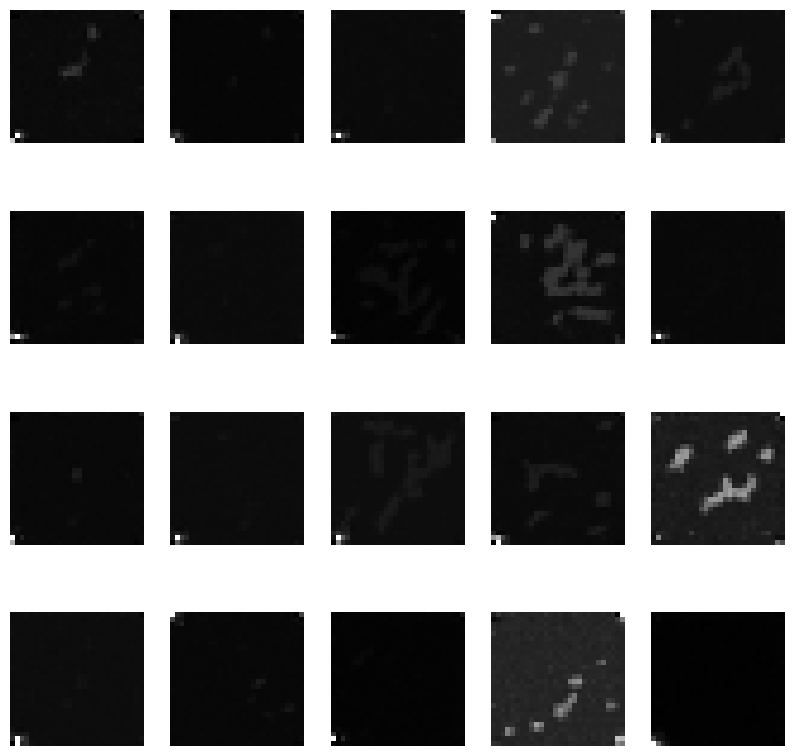

In [ ]:
sampled_images_2 = sample_from_model_2(score_net, diffusion, device, sample_size=100)

fig, axes = plt.subplots(4, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(sampled_images_2.cpu().detach().numpy()[i, 0], cmap='gray')
    ax.axis('off')
plt.show()

In [ ]:
# save model
torch.save(score_net.state_dict(), './score_net.pt')
torch.save(diffusion.state_dict(), './diffusion.pt')

In [ ]:
# load pretrained model
score_net = ScoreNet().to(device)
score_net.load_state_dict(torch.load('./score_net.pt'))
diffusion = Diffusion(score_net, T, device, min_beta, max_beta).to(device)
diffusion.load_state_dict(torch.load('./diffusion.pt'))

<All keys matched successfully>

## Evalutaion

In [ ]:
def calculate_fid_score(real_samples, generated_samples, eps=1e-4):
    real_samples = real_samples.cpu().detach().numpy()
    generated_samples = generated_samples.cpu().detach().numpy()

    mu_real = np.mean(real_samples, axis=0)
    mu_generated = np.mean(generated_samples, axis=0)

    cov_real = np.cov(real_samples[0][0], rowvar=False)
    cov_generated = np.cov(generated_samples[0][0], rowvar=False)

    # Add a small epsilon to the diagonal of covariance matrices to ensure they are positive definite
    cov_real += np.eye(cov_real.shape[0]) * eps
    cov_generated += np.eye(cov_generated.shape[0]) * eps

    mean_diff = mu_real - mu_generated
    mean_diff_squared = np.sum(mean_diff ** 2)

    cov_sqrt = np.sqrt(np.dot(cov_real, cov_generated))

    # If there are NaNs in the result, add a larger epsilon and recompute
    if np.isnan(cov_sqrt).any():
        cov_real += np.eye(cov_real.shape[0]) * 10 * eps
        cov_generated += np.eye(cov_generated.shape[0]) * 10 * eps
        cov_sqrt = np.sqrt(np.dot(cov_real, cov_generated))

    fid = mean_diff_squared + np.trace(cov_real) + np.trace(cov_generated) - 2 * np.trace(cov_sqrt)
    return fid

In [ ]:
real_images = []
for batch, _ in train_loader:
    real_images.append(batch)
real_images = torch.cat(real_images)[1500:1600]

calculate_fid_score(real_images, sampled_images_2, eps=1e-5)

nan